## Введение в CNN, классификация изображений

План:
1. Иллюстрация применения свёртки к изображению
2. `nn.Conv2D` и параметры
3. Max pooling, Average pooling, `nn.MaxPool2D`
4. Пример: классификация на CIFAR10
5. Модели в `torchvision`, transfer learning
6. Аугментации

In [ ]:
! pip install lightning==2.0.9 tensorboard==2.14.1

In [1]:
from typing import Callable, Iterator

import lightning as L
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.utilities.types import (
    EVAL_DATALOADERS,
    STEP_OUTPUT,
    TRAIN_DATALOADERS,
    OptimizerLRScheduler,
)
from PIL import Image
from torch import Tensor, nn
from torch.nn import functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
from torchvision import datasets, transforms

### 1. Свёртка

<img src="https://d2l.ai/_images/conv-pad.svg" style="background:white" width="400"/>

In [2]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)
for k, v in conv.named_parameters():
    print(k, v)

weight Parameter containing:
tensor([[[[0.4093, 0.0594],
          [0.0015, 0.2958]]]], requires_grad=True)
bias Parameter containing:
tensor([-0.3601], requires_grad=True)


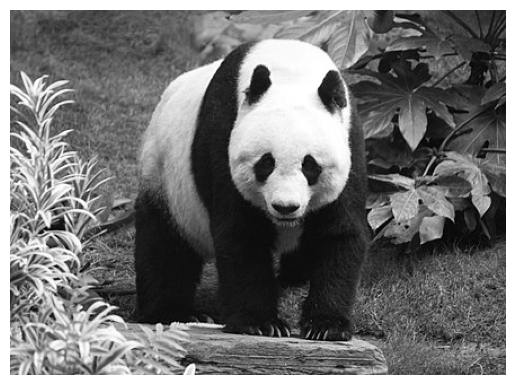

In [3]:
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/440px-Grosser_Panda.JPG"

img = Image.open(requests.get(IMAGE_URL, stream=True).raw)
grayscale = img.convert("L")

plt.imshow(grayscale, cmap="gray")
plt.axis(False)
plt.show()

Зададим несколько фильтров. Что они делают?

In [4]:
filters = {
    "0": torch.tensor([[[
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  0,  0],
    ]]], dtype=torch.float),
    "1": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "2": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "3": torch.tensor([[[
        [ 1,  2,  1],
        [ 2,  4,  2],
        [ 1,  2,  1],
    ]]], dtype=torch.float) / 16,
}

Посмотрим на результаты:

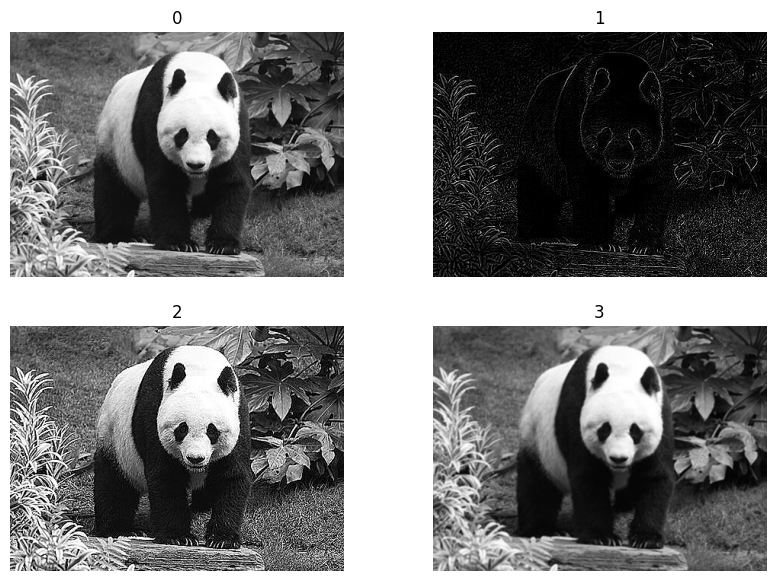

In [5]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 7))

# Создадим свёрточный слой и преобразуем изображение в тензор
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
img_tensor = transforms.ToTensor()(grayscale)

for k, (filter_name, filter_kernel) in enumerate(filters.items()):
    # подставим значения для фильтра в свёрточный слой
    conv.weight.data = filter_kernel

    # преобразуем входное изображение и обрежем до отрезка [0, 1] для корректного отображения
    transformed = conv(img_tensor).detach().numpy()[0].clip(0, 1)
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transformed, cmap="gray")
    ax.set_title(filter_name)
    ax.set_axis_off()

plt.show()

### 2. `nn.Conv2D`

Свёртка входного тензора размера $(N, C_{\text{in}}, H, W)$ в тензор размера $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$ описывается так:

<!-- In the simplest case, the output value of the layer with input size
$(N, C_{\text{in}}, H, W)$ and output $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$    can be precisely described as: -->
    
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)$$

$\star$ - 2D оператор кросс-корреляции, $N$ - размер батча, $C$ - количество каналов, $H$ и $W$ - высота и ширина в пикселах соответственно

<!-- $\star$ is the valid 2D `cross-correlation`_ operator,$N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels. -->

Каждый `nn.Conv2D` слой содержит две группы параметров:
- `weight`: тензор размера $(C_{out}, C_{in}, H_k, W_k)$
  - $C_{in}$: количество входных каналов
  - $C_{out}$: количество выходных каналов
  - $(H_k, W_k)$: размер 2D кернела (например, $3 \times 3$)
- `bias`: тензор размера $(C_{out},)$

Кроме того, регулировать количество параметров можно с помощью аргументов конструктора
- `bias (bool)`: включение / отключения параметра сдвига
- `groups`: число групп, на которые следует разбить входные и выходные каналы; каждый фильтр работает только с одной группой каналов

![GroupConv](https://www.researchgate.net/publication/351823568/figure/fig2/AS:1027082138181632@1621886872538/Standard-convolution-left-and-group-convolution-right.ppm)

**Упражнение**: сколько параметров будет в свёрточном слое с размером кернела $3 \times 3$ для преобразования тензора с 3 каналами в тензор с 6 каналами без группировки? С разделением на 3 группы?

Другие параметры, влияющие на результат свёртки
- `stride`: каков размер смещения между соседними срезами, к которым применяется свёртка
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

Демо: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/arbitrary_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/full_padding_no_strides.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides_odd.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/dilation.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>



### 3. Max pooling

![maxpool](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

Параметры инициализации `nn.MaxPool2d` (а так же `nn.AvgPool2d`) похожи на свёрточный слой:
- `kernel_size`: размер 2D кернела (обычно $2 \times 2$)
- `stride`: каков размер смещения между соседними срезами, к которым применяется pooling (обычно 2, т.е. без наложения)
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

Характерный строительный блок для свёрточной сети:
- `Conv -> ReLU -> MaxPool`
- В каждом следующем блоке размер активаций уменьшается (обычно в 4 раза), размер каналов увеличивается

Для того, чтобы перед линейным слоем размер активаций был одинаковым для любого размера входного изображения, есть `nn.AdaptiveMaxPool2d`

### 4. Пример: классификация CIFAR10

Модуль данных:

In [6]:
class CIFAR10(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        transform: Callable[[Image.Image], Tensor],
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform
        self.num_workers = num_workers

    def setup(self, stage: str) -> None:
        if stage == "fit":
            self.train_dataset = datasets.CIFAR10(
                root="./data", train=True, download=True, transform=self.transform
            )

        if stage in ("fit", "validate"):
            self.val_dataset = datasets.CIFAR10(
                root="./data", train=False, download=True, transform=self.transform
            )

        else:
            raise NotImplementedError(f"Stage '{stage}' not implemented for CIFAR10")

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

datamodule = CIFAR10(batch_size=32, transform=transform, num_workers=0)
datamodule.setup("fit")

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на примеры изображений:

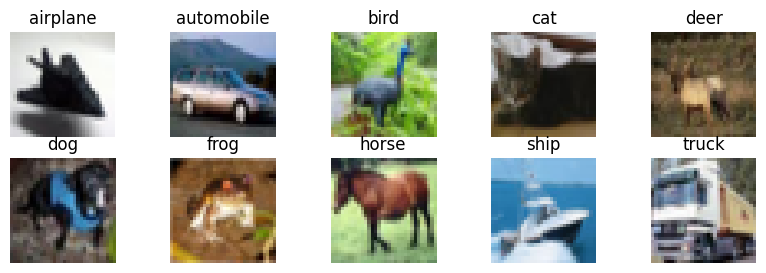

In [8]:
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3))
for k, label in enumerate(datamodule.train_dataset.classes):
    example = next(img for img, target in datamodule.train_dataset if target == k)
    # unnormalize images
    example = 0.5 * example + 0.5
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transforms.ToPILImage()(example), cmap="gray")
    ax.set_title(label)
    ax.set_axis_off()

plt.show()

LightningModule:

In [9]:
from typing import Any


from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class BaseVisionModel(nn.Module):
    def forward(self, images: Tensor) -> Tensor:
        ...

    @property
    def num_classes(self) -> int:
        ...


class VisionClassifier(L.LightningModule):
    def __init__(
        self,
        model: BaseVisionModel,
        optimizer_fn: Callable[[Iterator[nn.Parameter]], Optimizer],
    ) -> None:
        super().__init__()
        self.model = model
        self.optimizer = optimizer_fn(model.parameters())

        self.train_accuracy = MulticlassAccuracy(num_classes=model.num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=model.num_classes)


    def training_step(self, batch: tuple[Tensor, Tensor], batch_idx: int = 0) -> STEP_OUTPUT:
        images, target = batch
        logits = self.model.forward(images)
        loss = F.cross_entropy(logits, target)
        self.train_accuracy.update(logits, target)

        self.log("step", self.current_epoch, on_epoch=True, on_step=False)
        self.log("train/loss", loss, on_epoch=True, on_step=False)
        self.log("train/accuracy", self.train_accuracy.compute(), on_epoch=True, on_step=False)

        return loss
    
    def validation_step(self, batch: tuple[Tensor, Tensor], batch_idx: int = 0) -> STEP_OUTPUT:
        images, target = batch
        logits = self.model.forward(images)
        loss = F.cross_entropy(logits, target)
        self.val_accuracy.update(logits, target)

        self.log("step", self.current_epoch, on_epoch=True, on_step=False)
        self.log("val/loss", loss, on_epoch=True, on_step=False)
        self.log("val/accuracy", self.val_accuracy.compute(), on_epoch=True, on_step=False)

        return loss
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return self.optimizer

Определим простую архитектуру: 2 блока из свёртки и maxpooling, три линейных слоя, ReLU в качестве нелинейности

In [19]:
class Net(BaseVisionModel):
    def __init__(self, num_classes: int = 10, input_channels: int = 3):
        super().__init__()
        self._num_classes = num_classes
        # conv block
        self.conv1 = nn.Conv2d(input_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 32, 5)

        # linear block
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    @property
    def num_classes(self) -> int:
        return self._num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Напишем функцию для запуска обучения:

In [22]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint


def run_training(
    model: BaseVisionModel,
    datamodule: L.LightningDataModule,
    **trainer_kwargs,
) -> None:
    # создадим LightningModule
    lit = VisionClassifier(
        model=model,
        optimizer_fn=lambda params: torch.optim.Adam(params, lr=0.001),
    )
    # создадим логгер
    logger = TensorBoardLogger(save_dir="logs", name="cifar-10")

    # создадим Trainer и запустим обучение
    trainer = L.Trainer(
        logger=logger,
        **trainer_kwargs,
    )

    trainer.fit(
        model=lit,
        datamodule=datamodule,
    )

Tensorboard локально: `tensorboard --logdir logs/cifar-10`

Если запускаем в Colab - активируем расширение `tensorboard` прямо в ноутбуке:

In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir logs/cifar-10

In [ ]:
run_training(
    model=Net(num_classes=10),
    datamodule=datamodule,
    max_epochs=10,
    accelerator="gpu",
)

In [ ]:
sum([param.numel() for param in net.parameters()])

### 5. `torchvision.models`

Создание модели с нужными параметрами:

In [ ]:
from torchvision.models import MobileNetV2

mobilenet = MobileNetV2(
    num_classes=10,
    width_mult=1.0,
    inverted_residual_setting=[
        # t, c, n, s
        [1, 16, 1, 1],
        [3, 24, 2, 2],
        [3, 32, 3, 2],
    ],
    dropout=0.2,
)
# наш LightningModule ожидает, что у модели есть поле num_classes, чтобы правильно инициализировать метрики
mobilenet.num_classes = 10

# sum([param.numel() for param in mobilenet.parameters()])

run_training(
    model=mobilenet,
    datamodule=datamodule,
    max_epochs=10,
    accelerator="gpu",
)

Использование модели, предобученной на ImageNet:

In [35]:
from torchvision.models.efficientnet import EfficientNet_B0_Weights, efficientnet_b0

# создаём EfficientNet с весами, полученными на ImageNet
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
efficientnet = efficientnet_b0(weights=weights)

# замораживаем веса
for param in efficientnet.features[:-1].parameters():
    param.requires_grad = False

# меняем последний линейный слой
efficientnet.classifier[-1] = nn.Linear(
    in_features=efficientnet.classifier[-1].weight.shape[1], out_features=10
)
efficientnet.num_classes = 10
sum([param.numel() for param in efficientnet.parameters()])

4020358

Предобученные модели на ImageNet ожидают специальным образом трансформированные изображения. Здесь нам и пригодится параметр `transform` в нашем `LightningDataModule`

In [ ]:
datamodule = CIFAR10(
    batch_size=32,
    transform=weights.transforms(),
    num_workers=0,
)
run_training(model=efficientnet, datamodule=datamodule, accelerator="gpu")

### 6. Аугментации, `torchvision.transforms` и `albumentations`

`albumentations`

![albumentations](https://albumentations.ai/assets/img/custom/top_image.jpg)

### Упражнение

Обучите модель на CIFAR-10, дающую точность более 90% на тестовой выборке. Постарайтесь уложиться модель с ~5 млн параметров

Можно использовать:
- предобученные модели на ImageNet
- аугментации из `torchvision.transforms` и `albumentations`